In [1]:
from technicals import create_weekly_dataset, make_cycling_data, \
    train_test_split_each_route, pd, np, LabelEncoder, to_categorical, classify
    
import matplotlib.pyplot as plt

c:\Users\kubko\Documents\School\R_3\PRIDAV\PRIDAV-JPD\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import shuffle

from sklearn.metrics import classification_report as CR, ConfusionMatrixDisplay

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Input
plt.style.use('fivethirtyeight')

# Škálovanie a spájanie názvov

In [4]:
cycling_data = make_cycling_data()

In [5]:
X, y = create_weekly_dataset(cycling_data)
X = MinMaxScaler().fit_transform(X)
X = X.reshape(-1, 2,168)
s = pd.Series(y)
print("Počty vzoriek pre lokality:")
print(s.value_counts().to_string())


Počty vzoriek pre lokality:
Cyklomost            594
Hradza               575
Viedenska            575
Devinska Nova Ves    320
Dolnozemská          171
River Park           171
Starý Most           171
Devínska cesta       148
Most SNP             147
Vajnorská            147
Páričkova            147
Dunajská             145
Železná studnička    145
Most Apollo          144
Vajanského            98
Einsteinova           44
Trenčianska           44


In [6]:
X_train, X_test, y_train, y_test = train_test_split_each_route(X, y, test_size=0.3)

In [7]:
print(len(np.unique(y_train)))
counts = {"Názov":[],"Počet":[], "Počet test":[]}
for y in y_train:
    if y in counts["Názov"]:
        i = counts["Názov"].index(y)
        counts["Počet"][i] += 1
    else:
        counts["Názov"].append(y)
        counts["Počet"].append(1)
        counts["Počet test"].append(0)
for y in y_test:
    if y in counts["Názov"]:
        i = counts["Názov"].index(y)
        counts["Počet test"][i] += 1
        
x = pd.DataFrame(counts)
x.sort_values("Počet",ascending=False)

17


,Názov,Počet,Počet test
0,Cyklomost,415,179
6,Hradza,402,173
15,Viedenska,402,173
1,Devinska Nova Ves,224,96
3,Dolnozemská,119,52
10,River Park,119,52
11,Starý Most,119,52
2,Devínska cesta,103,45
8,Most SNP,102,45
14,Vajnorská,102,45


In [8]:
y_train, y_test, class_weights_dict, class_names = classify(y_train, y_test)

Klasifikujeme tieto lokality: ['Cyklomost' 'Devinska Nova Ves' 'Devínska cesta' 'Dolnozemská' 'Dunajská'
 'Einsteinova' 'Hradza' 'Most Apollo' 'Most SNP' 'Páričkova' 'River Park'
 'Starý Most' 'Trenčianska' 'Vajanského' 'Vajnorská' 'Viedenska'
 'Železná studnička'] 17


In [9]:
models = {"not_weighted_classes": Sequential(), "weighted_classes": Sequential()}
for model in models.values():
    model.add(Input(shape=(2,168)))
    model.add(Bidirectional(LSTM(72, return_sequences=False)))
    model.add(Dropout(0.4))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(len(class_names), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [10]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [11]:
history1 = models["not_weighted_classes"].fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=3)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [12]:
history2 = models["weighted_classes"].fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    verbose=3
)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [13]:
for name, model in models.items():
    print(f"\nVyhodnotenie modelu: {name}")
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nPresnosť na testovacích dátach: {accuracy*100:.2f}%")


Vyhodnotenie modelu: not_weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7690 - loss: 2.1377

Presnosť na testovacích dátach: 76.90%

Vyhodnotenie modelu: weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7559 - loss: 2.0677

Presnosť na testovacích dátach: 75.59%


In [14]:
for name, model in models.items():
    print(f"\nUkážka predikcie modelu: {name}")
    idx = 7
    pred_prob = model.predict(X_test[idx:idx+1])
    pred_label = class_names[np.argmax(pred_prob)]
    true_label = class_names[np.argmax(y_test[idx])]

    print(f"\nTest vzorka č.{idx}:")
    print(f"Realita:   {true_label}")
    print(f"Predikcia: {pred_label}")


Ukážka predikcie modelu: not_weighted_classes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step

Test vzorka č.7:
Realita:   Cyklomost
Predikcia: Cyklomost

Ukážka predikcie modelu: weighted_classes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step

Test vzorka č.7:
Realita:   Cyklomost
Predikcia: Cyklomost



Matica zámien pre model: not_weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


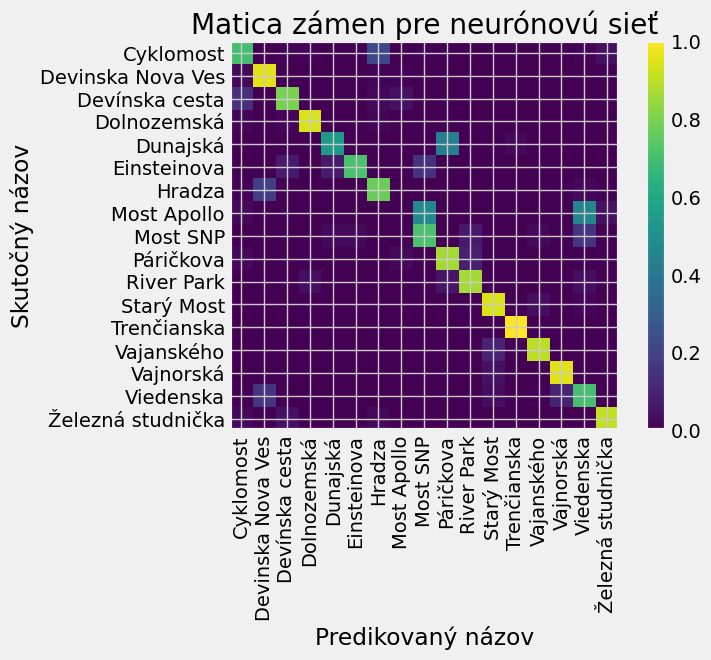


Matica zámien pre model: weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


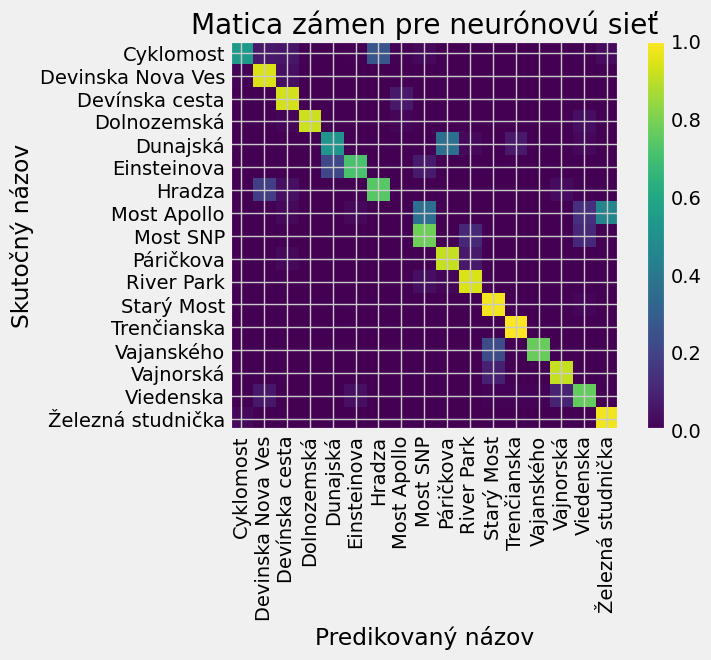

In [20]:
for name, model in models.items():
    print(f"\nMatica zámien pre model: {name}")
    ConfusionMatrixDisplay.from_predictions(
        np.argmax(y_test, axis=1),
        np.argmax(model.predict(X_test), axis=1),
        display_labels=class_names,
        cmap='viridis',
        xticks_rotation='vertical',
        normalize='true',
        include_values=False,
    )
    plt.xlabel("Predikovaný názov")
    plt.ylabel("Skutočný názov")
    plt.title("Matica zámen pre neurónovú sieť")
    plt.show()

In [42]:
for name, model in models.items():
    print(name)
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    errors = np.where(y_pred_classes != y_true_classes)[0]
    print(f"\nPočet nesprávnych klasifikácií: {len(errors)}")
    errors2 = np.where(np.argsort(y_pred_probs, axis=1)[:,-2][errors] == y_true_classes[errors])[0]
    print(f"Počet klasifikácii, kde druhá najpravdepodobnejšia predikcia je správna: {len(errors2)}")
    errors3 = np.where(np.argsort(y_pred_probs, axis=1)[:,-3][errors] == y_true_classes[errors])[0]
    print(f"Počet klasifikácii, kde tretia najpravdepodobnejšia predikcia je správna: {len(errors3)}")


    print("\nDetailná klasifikačná správa:")
    df = pd.DataFrame(CR(y_true_classes, y_pred_classes, target_names=class_names,output_dict=True)).T
    #print(CR(y_true_classes, y_pred_classes, target_names=class_names,output_dict=True))

df[["precision","recall","f1-score"]] = (df[["precision","recall","f1-score"]] * 100).round(2)
df["support"] = df["support"].apply(lambda x: int(x))
df

not_weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Počet nesprávnych klasifikácií: 265
Počet klasifikácii, kde druhá najpravdepodobnejšia predikcia je správna: 137
Počet klasifikácii, kde tretia najpravdepodobnejšia predikcia je správna: 51

Detailná klasifikačná správa:
weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Počet nesprávnych klasifikácií: 280
Počet klasifikácii, kde druhá najpravdepodobnejšia predikcia je správna: 121
Počet klasifikácii, kde tretia najpravdepodobnejšia predikcia je správna: 65

Detailná klasifikačná správa:


,precision,recall,f1-score,support
Cyklomost,97.96,53.63,69.31,179
Devinska Nova Ves,62.33,94.79,75.21,96
Devínska cesta,62.69,93.33,75.00,45
Dolnozemská,97.96,92.31,95.05,52
Dunajská,88.46,52.27,65.71,44
Einsteinova,52.63,71.43,60.61,14
Hradza,73.14,73.99,73.56,173
Most Apollo,0.00,0.00,0.00,44
Most SNP,60.34,77.78,67.96,45
Páričkova,70.69,91.11,79.61,45
